In [68]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import pyramid as pm
from sklearn.externals import joblib
from collections import defaultdict
import os
print(print(pm.__version__))

0.8.1
None


In [86]:
def seasonal_MASE(last_season, this_season, forecast):
    '''
    Parameters
    ----------
    last_season: array containing data for last season (size S)
    
    current_truth: array containing data for current season (size S)
    
    forecast: array containing data predictiing current season (size S)
    '''
    forecast_errors = np.abs(this_season - forecast)
    #print(forecast_errors)
    mean_absolute_forecast_error = np.average(forecast_errors)
    #print('forecast MAE', mean_absolute_forecast_error)
    
    naive = last_season
    naive.index = this_season.index
    naive_errors = np.abs(this_season - naive)
    #print(naive_errors)
    mean_absolute_naive_error = np.average(naive_errors)
    #print('naive MAE', mean_absolute_naive_error)
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

In [69]:
dn = pd.read_csv('../datasets/nights_2010-2017.csv',parse_dates=['date'], index_col='date',usecols=[*range(1, 15)])
dm = pd.read_csv('../datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
dh = pd.read_csv('../datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
dg = pd.read_csv('../datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
dr = pd.concat([dn,dm,dh,dg], axis=1)
regions = [x.replace('nights_','') for x in list(dn.columns)]
regions.sort()

In [70]:
predict_year=2016
train_start='2010-01-01'
for region in regions:
    print("Create SARIMAX model for region:",region,"\nPrediction year:",predict_year)
    train_end = str(predict_year-1)+'-12-01'
    predict_start = str(predict_year)+'-01-01'
    predict_end = str(predict_year)+'-12-01'
    dfr = dr.loc[train_start:predict_end,dr.columns.str.contains(""+region+"|daysoff")]
    df_train = dfr.loc[train_start:train_end,dfr.columns.str.startswith('nights')]
    df_test = dfr.loc[predict_start:predict_end ,dfr.columns.str.startswith('nights')]
    df_train_exogenous = dfr.loc[train_start:train_end,~dfr.columns.str.startswith('nights')]
    df_test_exogenous =  dfr.loc[predict_start:predict_end,~dfr.columns.str.startswith('nights')]
    train = np.array(df_train)
    train_exogenous= np.array(df_train_exogenous)
    test = np.array(df_test)
    test_exogenous=np.array(df_test_exogenous)
    start_p = 1
    start_q = 1
    start_P = 1
    if region in ['ARA','HDF','COR','GES','BFC']:
        start_p = 0
        start_q = 0
        start_P = 0
    model = pm.auto_arima(y=train,exogenous=train_exogenous,start_p=start_p, start_q=start_q, max_p=3, max_q=3, m=12,
                     start_P=start_P, seasonal=True, d=1, D=1, trace=False,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)
    start_P = model.seasonal_order[0]
    if region == 'IDF' :
        start_P = model.seasonal_order[0]
        model0 = pm.auto_arima (y=train,exogenous=train_exogenous, start_p=5, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=start_P, seasonal=True, n_jobs=-1, d=1, D=1, trace=False,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=False, random=True, random_state=42,  # we can fit a random search (not exhaustive)
                    n_fits=25)
        max_p = model0.order[0]
        max_q = model0.order[2]
        model = pm.auto_arima(y=train,exogenous=train_exogenous,start_p=max_p, start_q=max_q, max_p=max_p, max_q=max_q, m=12,
                     start_P=model0.seasonal_order[0], seasonal=True, d=1, D=1, trace=False,
                     error_action='ignore',  # don't want to know if an order does not work
                     suppress_warnings=True,  # don't want convergence warnings
                     stepwise=True)
    
    joblib_file = region+".pkl"  
    joblib.dump(model,joblib_file)

Create SARIMAX model for region: ARA 
Prediction year: 2016
Create SARIMAX model for region: BFC 
Prediction year: 2016
Create SARIMAX model for region: BRE 
Prediction year: 2016
Create SARIMAX model for region: COR 
Prediction year: 2016
Create SARIMAX model for region: CVL 
Prediction year: 2016
Create SARIMAX model for region: GES 
Prediction year: 2016
Create SARIMAX model for region: HDF 
Prediction year: 2016
Create SARIMAX model for region: IDF 
Prediction year: 2016
Create SARIMAX model for region: NAQ 
Prediction year: 2016
Create SARIMAX model for region: NOR 
Prediction year: 2016
Create SARIMAX model for region: OCC 
Prediction year: 2016
Create SARIMAX model for region: PAC 
Prediction year: 2016
Create SARIMAX model for region: PDL 
Prediction year: 2016


In [72]:
for region in regions:
    mc_fit = pm.auto_arima(y=np.array(train_data_2010_2015['gdp_'+region]),start_p=0, start_q=0, max_p=3, max_q=3, m=12,
                    start_P=1, seasonal=False, d=1, D=1, trace=False,
                    error_action='ignore',  # don't want to know if an order does not work
                    suppress_warnings=True,  # don't want convergence warnings
                    stepwise=True)
    next_24 = mc_fit.predict(n_periods=24)
    dr.loc['2016-01-01':'2017-12-01','gdp_'+region] = next_24

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/aa/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interprete

In [87]:
train_start = '2010-01-01'
all_mae = defaultdict(dict)
all_rmse = defaultdict(dict)
years_data = defaultdict(dict)
predicted_data = defaultdict(list)
all_smase = defaultdict(dict)
for region in regions:
    joblib_file = region+".pkl"
    joblib_model = joblib.load(joblib_file)
    for predict_year in range(2011,2018):
        print("Cross Validation SARIMAX Region:",region,"Prediction year:",predict_year)
        train_end = str(predict_year-1)+'-12-01'
        predict_start = str(predict_year)+'-01-01'
        predict_end = str(predict_year)+'-12-01'
        dfr = dr.loc[train_start:predict_end,dr.columns.str.contains(""+region+"|daysoff")]
        df_train = dfr.loc[train_start:train_end,dfr.columns.str.startswith('nights')]
        df_test = dfr.loc[predict_start:predict_end ,dfr.columns.str.startswith('nights')]
        df_train_exogenous = dfr.loc[train_start:train_end,~dfr.columns.str.startswith('nights')]
        df_test_exogenous =  dfr.loc[predict_start:predict_end,~dfr.columns.str.startswith('nights')]
        train = np.array(df_train)
        train_exogenous= np.array(df_train_exogenous)
        test = np.array(df_test)
        test_exogenous=np.array(df_test_exogenous)
        if predict_year != 2016: 
            tc_fit = pm.arima.ARIMA (order=joblib_model.order,seasonal_order=joblib_model.seasonal_order,start_params=joblib_model.params())
            tc_fit.fit(train,train_exogenous)
            future_forecast = tc_fit.predict(n_periods=12,exogenous = test_exogenous)
        else:
            future_forecast = joblib_model.predict(n_periods=12,exogenous = test_exogenous)
        # --------Calculated error measures for each CV step----------
        mae = mean_absolute_error(test, future_forecast)
        mse = mean_squared_error(test,future_forecast)
        rmse = sqrt(mse)
        years_data[region][predict_year]=list(range(2010,predict_year))
        predicted_data[region].append(predict_year)
        all_mae[region][predict_year]=mae
        all_rmse[region][predict_year]=rmse
        lastyear_start = str(predict_year-1)+'-01-01'
        lastyear_end = str(predict_year-1)+'-12-01'
        forecast = pd.DataFrame(future_forecast,columns=['nights_'+region], index=df_test.index)
        all_smase[region][predict_year] = seasonal_MASE(dfr.loc[lastyear_start:lastyear_end,dfr.columns.str.contains('nights_'+region)], df_test, forecast )


Cross Validation SARIMAX Region: ARA Prediction year: 2011
Cross Validation SARIMAX Region: ARA Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2014
Cross Validation SARIMAX Region: ARA Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: ARA Prediction year: 2016
Cross Validation SARIMAX Region: ARA Prediction year: 2017
Cross Validation SARIMAX Region: BFC Prediction year: 2011
Cross Validation SARIMAX Region: BFC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BFC Prediction year: 2015
Cross Validation SARIMAX Region: BFC Prediction year: 2016
Cross Validation SARIMAX Region: BFC Prediction year: 2017
Cross Validation SARIMAX Region: BRE Prediction year: 2011
Cross Validation SARIMAX Region: BRE Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Cross Validation SARIMAX Region: BRE Prediction year: 2013
Cross Validation SARIMAX Region: BRE Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BRE Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: BRE Prediction year: 2016
Cross Validation SARIMAX Region: BRE Prediction year: 2017
Cross Validation SARIMAX Region: COR Prediction year: 2011
Cross Validation SARIMAX Region: COR Prediction year: 2012
Cross Validation SARIMAX Region: COR Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: COR Prediction year: 2014
Cross Validation SARIMAX Region: COR Prediction year: 2015
Cross Validation SARIMAX Region: COR Prediction year: 2016
Cross Validation SARIMAX Region: COR Prediction year: 2017
Cross Validation SARIMAX Region: CVL Prediction year: 2011
Cross Validation SARIMAX Region: CVL Prediction year: 2012
Cross Validation SARIMAX Region: CVL Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: CVL Prediction year: 2014
Cross Validation SARIMAX Region: CVL Prediction year: 2015
Cross Validation SARIMAX Region: CVL Prediction year: 2016
Cross Validation SARIMAX Region: CVL Prediction year: 2017
Cross Validation SARIMAX Region: GES Prediction year: 2011
Cross Validation SARIMAX Region: GES Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: GES Prediction year: 2016
Cross Validation SARIMAX Region: GES Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2011
Cross Validation SARIMAX Region: HDF Prediction year: 2012
Cross Validation SARIMAX Region: HDF Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2014
Cross Validation SARIMAX Region: HDF Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: HDF Prediction year: 2016
Cross Validation SARIMAX Region: HDF Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2011
Cross Validation SARIMAX Region: IDF Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: IDF Prediction year: 2016
Cross Validation SARIMAX Region: IDF Prediction year: 2017
Cross Validation SARIMAX Region: NAQ Prediction year: 2011
Cross Validation SARIMAX Region: NAQ Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NAQ Prediction year: 2016
Cross Validation SARIMAX Region: NAQ Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: NOR Prediction year: 2011
Cross Validation SARIMAX Region: NOR Prediction year: 2012
Cross Validation SARIMAX Region: NOR Prediction year: 2013
Cross Validation SARIMAX Region: NOR Prediction year: 2014
Cross Validation SARIMAX Region: NOR Prediction year: 2015
Cross Validation SARIMAX Region: NOR Prediction year: 2016
Cross Validation SARIMAX Region: NOR Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2011
Cross Validation SARIMAX Region: OCC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2014


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: OCC Prediction year: 2016
Cross Validation SARIMAX Region: OCC Prediction year: 2017


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2011
Cross Validation SARIMAX Region: PAC Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2014
Cross Validation SARIMAX Region: PAC Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PAC Prediction year: 2016
Cross Validation SARIMAX Region: PAC Prediction year: 2017
Cross Validation SARIMAX Region: PDL Prediction year: 2011
Cross Validation SARIMAX Region: PDL Prediction year: 2012


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2013


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2014
Cross Validation SARIMAX Region: PDL Prediction year: 2015


/home/aa/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Cross Validation SARIMAX Region: PDL Prediction year: 2016
Cross Validation SARIMAX Region: PDL Prediction year: 2017


Region ARA
Years of training data: [2010]
Predicted year: 2011
RMSE: 74.067363
MAE: 62.277674
MASE: 0.649662
Years of training data: [2010, 2011]
Predicted year: 2012
RMSE: 4353.470187
MAE: 4353.036571
MASE: 69.459655
Years of training data: [2010, 2011, 2012]
Predicted year: 2013
RMSE: 78.283097
MAE: 62.372236
MASE: 0.878276
Years of training data: [2010, 2011, 2012, 2013]
Predicted year: 2014
RMSE: 107.858282
MAE: 79.075944
MASE: 0.746792
Years of training data: [2010, 2011, 2012, 2013, 2014]
Predicted year: 2015
RMSE: 85.176903
MAE: 73.246572
MASE: 0.751928
Years of training data: [2010, 2011, 2012, 2013, 2014, 2015]
Predicted year: 2016
RMSE: 180.487801
MAE: 168.463905
MASE: 1.890835
Years of training data: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Predicted year: 2017
RMSE: 64.142703
MAE: 51.900215
MASE: 0.783764
Region BFC
Years of training data: [2010]
Predicted year: 2011
RMSE: 21.899779
MAE: 17.849946
MASE: 1.132671
Years of training data: [2010, 2011]
Predicted year: 2012
RM

Region OCC
Years of training data: [2010]
Predicted year: 2011
RMSE: 334.941217
MAE: 332.481008
MASE: 9.132003
Years of training data: [2010, 2011]
Predicted year: 2012
RMSE: 1611.654489
MAE: 1610.849304
MASE: 46.689029
Years of training data: [2010, 2011, 2012]
Predicted year: 2013
RMSE: 85.928411
MAE: 68.420678
MASE: 1.168702
Years of training data: [2010, 2011, 2012, 2013]
Predicted year: 2014
RMSE: 59.826590
MAE: 51.363644
MASE: 1.131296
Years of training data: [2010, 2011, 2012, 2013, 2014]
Predicted year: 2015
RMSE: 69.150434
MAE: 64.190378
MASE: 1.881450
Years of training data: [2010, 2011, 2012, 2013, 2014, 2015]
Predicted year: 2016
RMSE: 46.054701
MAE: 34.562205
MASE: 0.695953
Years of training data: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
Predicted year: 2017
RMSE: 45.700074
MAE: 37.696613
MASE: 0.870273
Region PAC
Years of training data: [2010]
Predicted year: 2011
RMSE: 1248.575436
MAE: 1245.654713
MASE: 12.294263
Years of training data: [2010, 2011]
Predicted year: 201

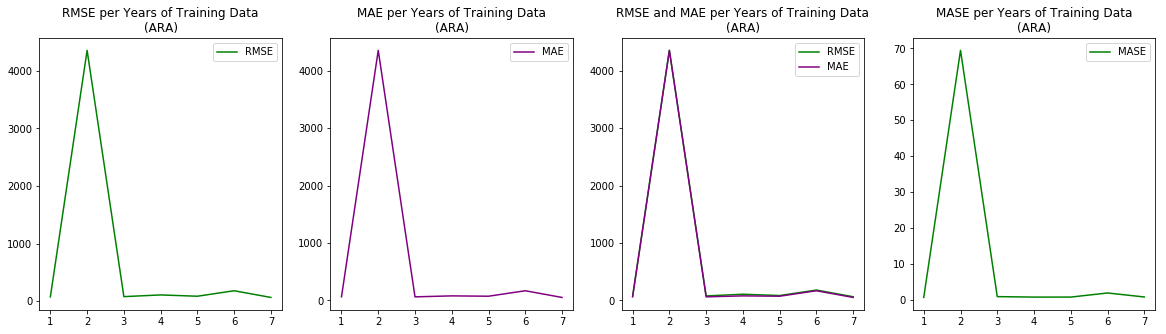

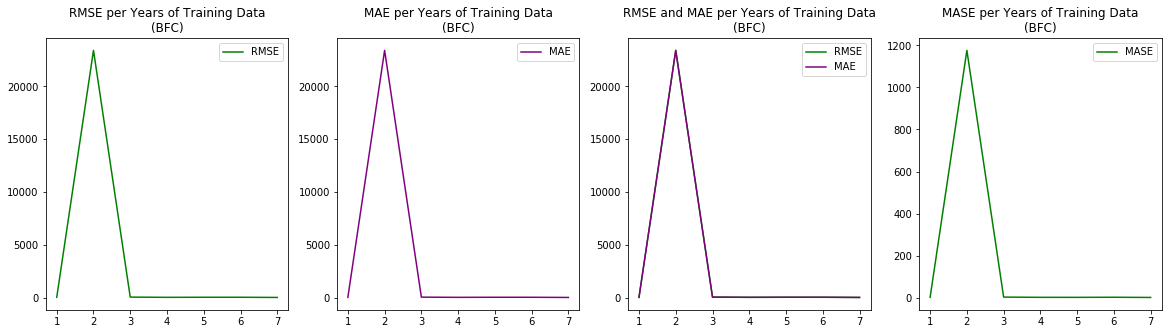

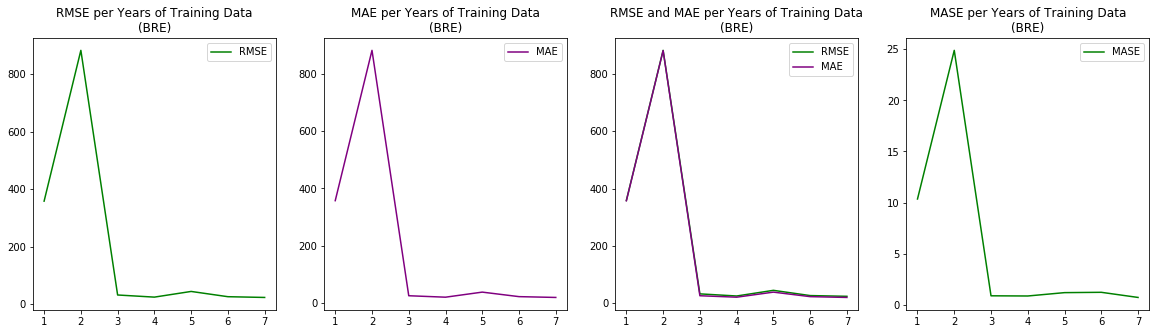

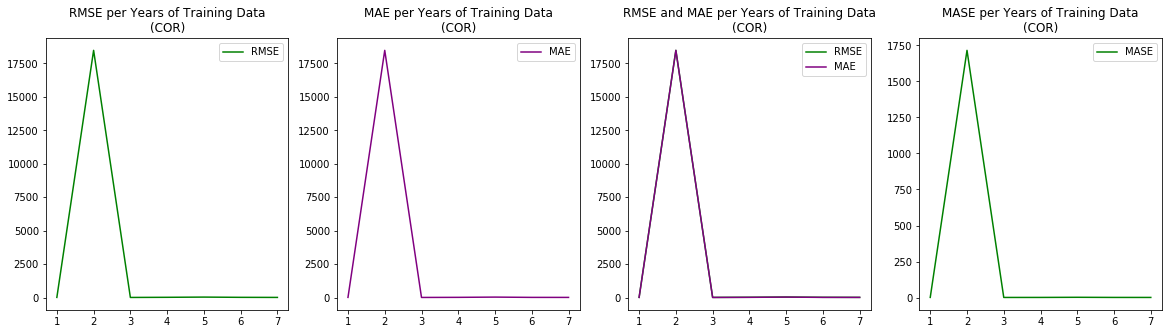

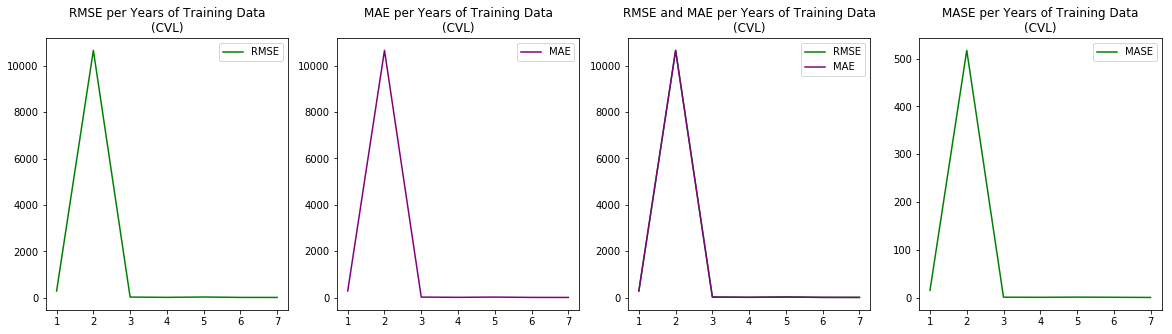

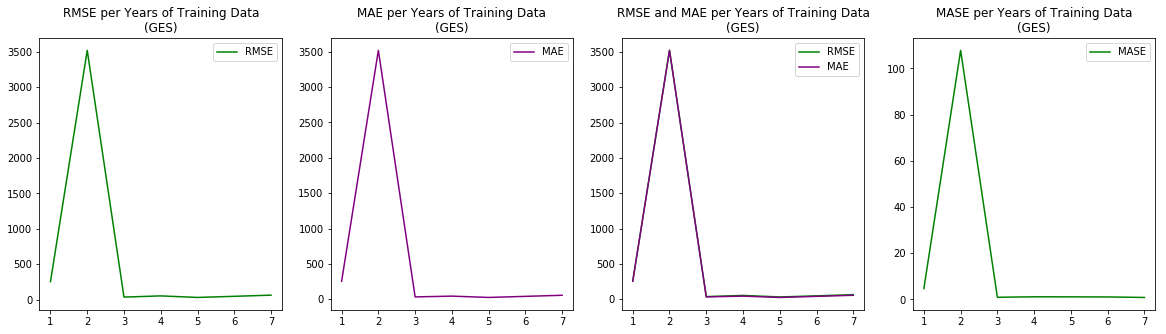

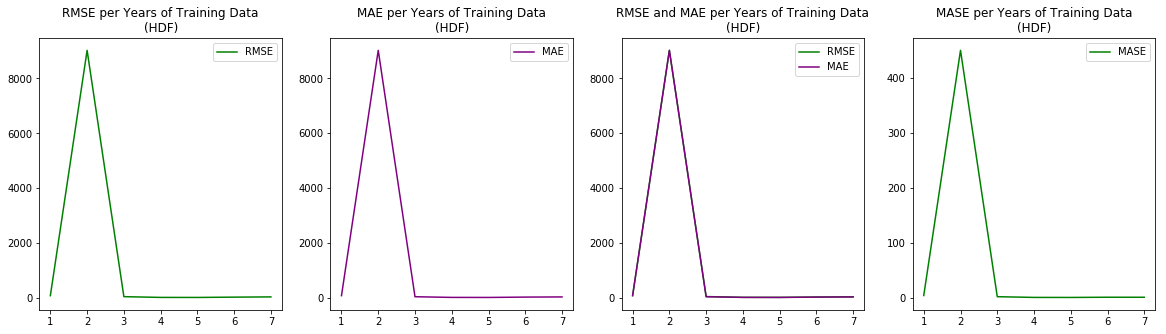

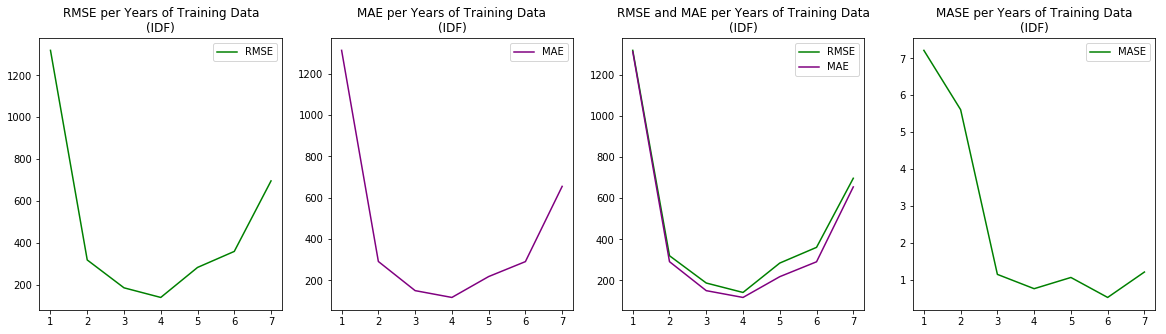

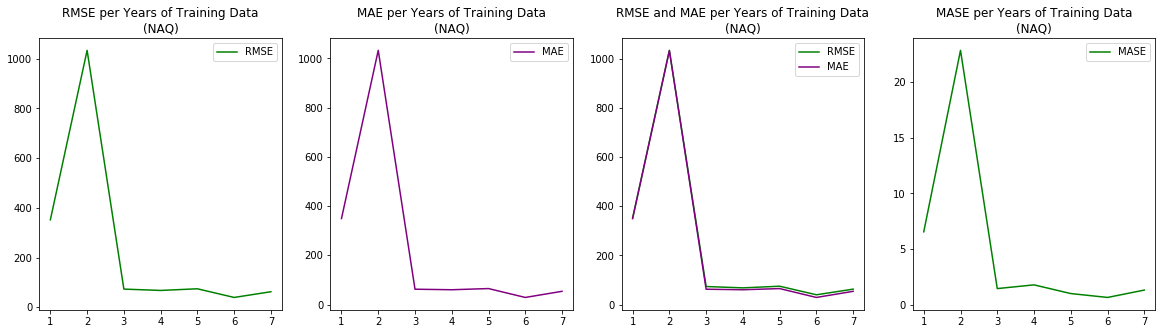

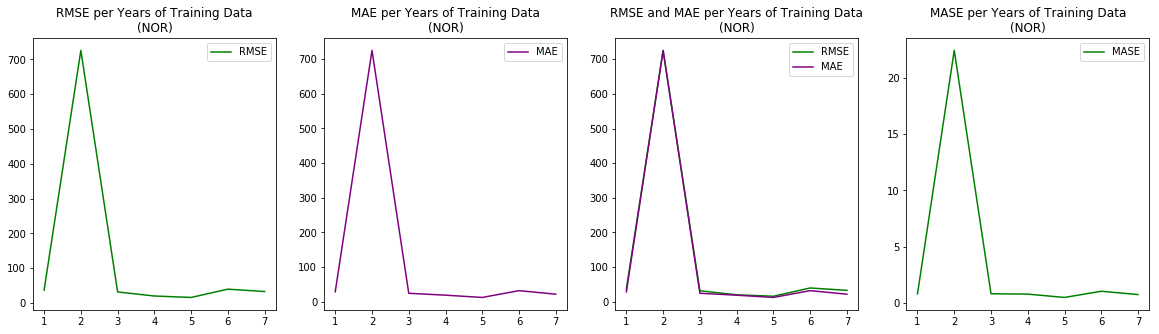

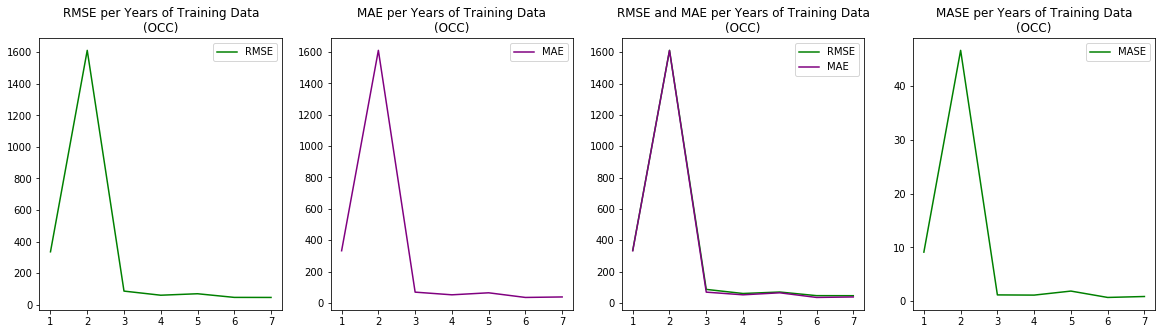

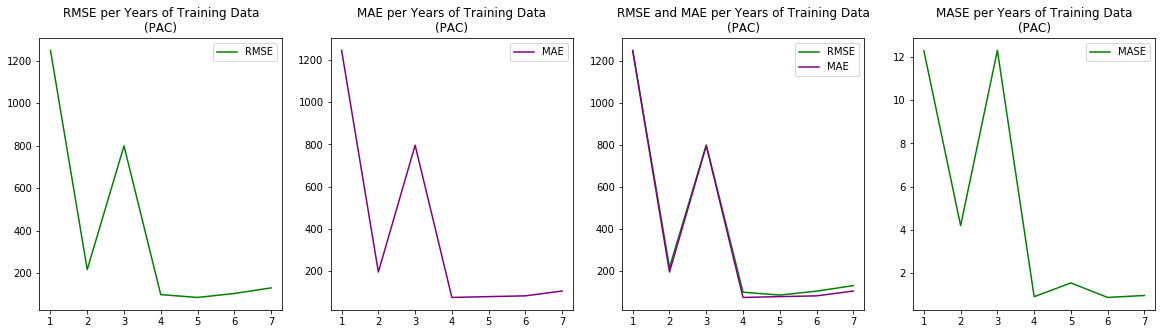

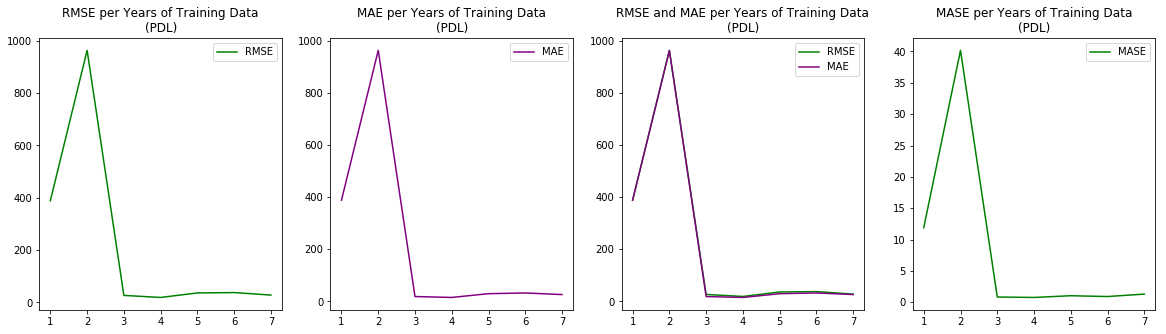

In [88]:
regions = [x.replace('nights_','') for x in list(dn.columns)]
regions.sort()
for region in regions:
        print("Region",region)
        for year in predicted_data[region]:
            print('Years of training data:', years_data[region][year])
            print('Predicted year:', year)
            print('RMSE: %f' % all_rmse[region][year])
            print('MAE: %f' % all_mae[region][year])
            print('MASE: %f' % all_smase[region][year])
        # Error measures per CrossVal loop (number of years of training data used)
        years = predicted_data[region]   
        fig, axes = plt.subplots(1,4, figsize=(20,5))
        x = [len(v)    for k,v in years_data[region].items()]
        axes[0].plot(x, np.array([all_rmse[region][index] for index in years]), label='RMSE', color='green')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(x)
        axes[0].set_title('RMSE per Years of Training Data' + '\n' + f'({region})')
        axes[0].legend()

        axes[1].plot(x, [all_mae[region][index] for index in years], label='MAE', color='purple')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(x)
        axes[1].set_title('MAE per Years of Training Data' + '\n' + f'({region})')
        axes[1].legend()

        axes[2].plot(x, [all_rmse[region][index] for index in years], label='RMSE', color='green')
        axes[2].plot(x, [all_mae[region][index] for index in years], label='MAE', color='purple')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(x)
        axes[2].set_title('RMSE and MAE per Years of Training Data' + '\n' + f'({region})')
        axes[2].legend();   
        
        axes[3].plot(x, np.array([all_smase[region][index] for index in years]), label='MASE', color='green')
        axes[3].set_xticks(x)
        axes[3].set_xticklabels(x)
        axes[3].set_title('MASE per Years of Training Data' + '\n' + f'({region})')
        axes[3].legend()
        plt.savefig('CrossValidation_SARIMAX'+region+'.png')